# Image Analysis - Malaria Detection

In [21]:
# load the packages
from pyimagesearch import config
from pyimagesearch.resnet import ResNet
from imutils import paths
import random
import shutil
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras import optimizers
from keras.applications import VGG16
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "malaria/cell_images"

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = "malaria"

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the *training* data
VAL_SPLIT = 0.1

In [3]:
# grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [4]:
# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i] # 80% of the data
testPaths = imagePaths[i:] # 20% of the data

# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i] # 8% of the data
trainPaths = trainPaths[i:] #72% of the data

In [5]:
# define the datasets that we'll be building
datasets = [
    ("training", trainPaths, config.TRAIN_PATH),
    ("validation", valPaths, config.VAL_PATH),
    ("testing", testPaths, config.TEST_PATH)
]

In [6]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
    
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
        
    # loop over the input image paths
    for inputPath in imagePaths:
        
        # extract the filename of the input image along with its corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]

        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
            
        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split


In [7]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

In [8]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 90,
    zoom_range = [0.5, 1.5],
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.5, 1.5],
    fill_mode = "nearest")
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale = 1 / 255.0)

In [9]:
# initialize the training generator
batch_size = 20

trainGen = trainAug.flow_from_directory(
    config.TRAIN_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    config.VAL_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    config.TEST_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [10]:
conv_base = VGG16(weights = "imagenet", include_top = False)
conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________

In [11]:
# Use the following code to extract the features and labels

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if ((i * batch_size % 1000) == 0 ):
            print("processed size =", i * batch_size)
        if i * batch_size >= sample_count:
            break
    return features, labels

In [12]:
train_features, train_labels = extract_features(trainGen, totalTrain)
validation_features, validation_labels = extract_features(valGen, totalVal)
test_features, test_labels = extract_features(testGen, totalTest)
train_features = np.reshape(train_features, (totalTrain, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (totalVal, 4 * 4 * 512))
test_features = np.reshape(test_features, (totalTest, 4 * 4 * 512))


processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000
processed size = 6000
processed size = 7000
processed size = 8000
processed size = 9000
processed size = 10000
processed size = 11000
processed size = 12000
processed size = 13000
processed size = 14000
processed size = 15000
processed size = 16000
processed size = 17000
processed size = 18000
processed size = 19000
processed size = 1000
processed size = 2000
processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000


In [13]:
np.save('train_features', train_features)
np.save('val_features', validation_features)
np.save('test_features', test_features)

In [14]:
train_features = np.load('train_features.npy')
val_features = np.load('val_features.npy')
test_features = np.load('test_features.npy')

In [26]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=5,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/10
19842/19842 [==============================] - 40s 2ms/step - loss: 0.4598 - accuracy: 0.7781 - val_loss: 0.2995 - val_accuracy: 0.8684
Epoch 2/10
19842/19842 [==============================] - 38s 2ms/step - loss: 0.3682 - accuracy: 0.8433 - val_loss: 0.3025 - val_accuracy: 0.8648
Epoch 3/10
19842/19842 [==============================] - 37s 2ms/step - loss: 0.3483 - accuracy: 0.8565 - val_loss: 0.2636 - val_accuracy: 0.8884
Epoch 4/10
19842/19842 [==============================] - 36s 2ms/step - loss: 0.3410 - accuracy: 0.8622 - val_loss: 0.2512 - val_accuracy: 0.9120
Epoch 5/10
19842/19842 [==============================] - 36s 2ms/step - loss: 0.3356 - accuracy: 0.8661 - val_loss: 0.2411 - val_accuracy: 0.9083
Epoch 6/10
19842/19842 [==============================] - 37s 2ms/step - loss: 0.3282 - accuracy: 0.8720 - val_loss: 0.3103 - val_accuracy: 0.8684
Epoch 7/10
19842/19842 [==============================] - 37s 2ms/ste

In [27]:
accuracy = model.evaluate(test_features, test_labels, batch_size=batch_size)
print("Accuracy: ", accuracy[1])

5512/5512 [==============================] - 0s 89us/step
Accuracy:  0.920536994934082


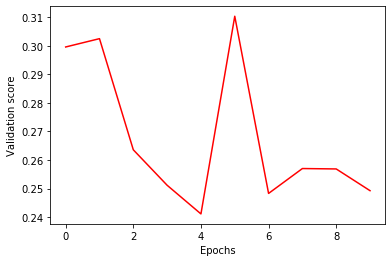

In [28]:
# Create the plot of the validation loss to compare different models
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [39]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/10
19842/19842 [==============================] - 61s 3ms/step - loss: 0.5281 - accuracy: 0.7285 - val_loss: 0.3460 - val_accuracy: 0.8426
Epoch 2/10
19842/19842 [==============================] - 59s 3ms/step - loss: 0.4043 - accuracy: 0.8182 - val_loss: 0.3156 - val_accuracy: 0.8489
Epoch 3/10
19842/19842 [==============================] - 60s 3ms/step - loss: 0.3708 - accuracy: 0.8382 - val_loss: 0.2912 - val_accuracy: 0.8721
Epoch 4/10
19842/19842 [==============================] - 67s 3ms/step - loss: 0.3487 - accuracy: 0.8512 - val_loss: 0.2740 - val_accuracy: 0.8793
Epoch 5/10
19842/19842 [==============================] - 63s 3ms/step - loss: 0.3362 - accuracy: 0.8560 - val_loss: 0.2495 - val_accuracy: 0.9111
Epoch 6/10
19842/19842 [==============================] - 68s 3ms/step - loss: 0.3222 - accuracy: 0.8669 - val_loss: 0.2569 - val_accuracy: 0.8884
Epoch 7/10
19842/19842 [==============================] - 74s 4ms/ste

In [40]:
model.adaccuracy = model.evaluate(test_features, test_labels, batch_size=batch_size)
print("Accuracy: ", accuracy[1])

5512/5512 [==============================] - 2s 282us/step
Accuracy:  0.9167271256446838


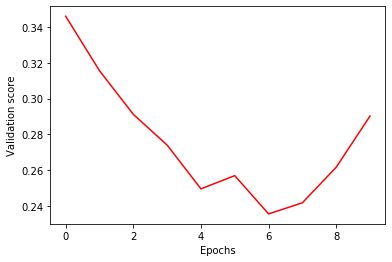

In [41]:
# Create the plot of the validation loss to compare different models
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [35]:
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 19842 samples, validate on 2204 samples
Epoch 1/10
19842/19842 [==============================] - 6s 323us/step - loss: 0.5196 - accuracy: 0.7429 - val_loss: 0.3414 - val_accuracy: 0.8507
Epoch 2/10
19842/19842 [==============================] - 7s 355us/step - loss: 0.3849 - accuracy: 0.8327 - val_loss: 0.2900 - val_accuracy: 0.8911
Epoch 3/10
19842/19842 [==============================] - 6s 303us/step - loss: 0.3512 - accuracy: 0.8529 - val_loss: 0.4153 - val_accuracy: 0.8203
Epoch 4/10
19842/19842 [==============================] - 7s 337us/step - loss: 0.3298 - accuracy: 0.8629 - val_loss: 0.2495 - val_accuracy: 0.9038
Epoch 5/10
19842/19842 [==============================] - 7s 330us/step - loss: 0.3150 - accuracy: 0.8703 - val_loss: 0.3994 - val_accuracy: 0.8330
Epoch 6/10
19842/19842 [==============================] - 6s 303us/step - loss: 0.3044 - accuracy: 0.8759 - val_loss: 0.2406 - val_accuracy: 0.9056
Epoch 7/10
19842/19842 [==============================] - 5s 25

In [36]:
accuracy = model.evaluate(test_features, test_labels, batch_size=batch_size)
print("Accuracy: ", accuracy[1])

5512/5512 [==============================] - 0s 88us/step
Accuracy:  0.9167271256446838


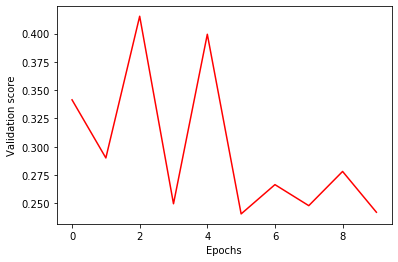

In [37]:
# Create the plot of the validation loss to compare different models
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()